# Exploring Moscow Neighbourhoods with foursquare API

## importing libraries

In [143]:
import copy
import numpy as np
import pandas as pd
import random
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import scipy.stats as stats
import sklearn as skl
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Hello pumpkin world!')

Hello pumpkin world!


In [144]:
!pip install beautifulsoup4

In [145]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

In [146]:
import json # library to handle JSON files

!pip install geopy
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data importing

In [147]:
# getting the data from wikipedia
wikiurl = requests.get('https://en.wikipedia.org/wiki/Category:Districts_of_Moscow').text 
soup = BeautifulSoup(wikiurl, 'lxml')

In [148]:
mwcg = soup.find_all(class_ = "mw-category-group")

csv_file = open('moscow.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

length = len(mwcg) # Gets the length of number of `mw-category-groups` present

for i in range(1, length):  # Gets all the neighbourhoods
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title') # Gets the title of the neighbourhood
        csv_writer.writerow([nbd]) # Writes the name of the neighbourhood in the csv file
csv_file.close()

In [149]:
moscow_dist = pd.read_csv('moscow.csv')

In [150]:
# taking first look to Moscow dataset
moscow_dist.head(10)

,Neighbourhood
0,Category:Brateyevo District
1,Category:Khamovniki District
2,Category:Matushkino District
3,Category:Meshchansky District
4,Category:Staroye Kryukovo District
5,Category:Tverskoy District
6,Category:Zamoskvorechye District
7,Aeroport District
8,Akademichesky District
9,"Alexeyevsky District, Moscow"


## Clearing the data

In [151]:
# if we open the csv file we could see that some values are duplicated
# as soon as the first seven rows are duplicates they can be removed
moscow_dist = moscow_dist.loc[7:]

In [152]:
moscow_dist.head(10)

,Neighbourhood
7,Aeroport District
8,Akademichesky District
9,"Alexeyevsky District, Moscow"
10,Altufyevsky District
11,"Babushkinsky District, Moscow"
12,Basmanny District
13,Begovoy District
14,Beskudnikovsky District
15,Bibirevo District
16,Biryulyovo Vostochnoye District


In [153]:
# length of dataset is 121 rows
moscow_dist.shape

(121, 1)

In [154]:
# let's format each row to certain look
# here we're adding ',Moscow' string to every row without it
for i in moscow_dist['Neighbourhood']:    
    if i[-8::] != ', Moscow':
        moscow_dist['Neighbourhood'].replace([i], i+', Moscow', inplace=True)
moscow_dist.head(10)

,Neighbourhood
7,"Aeroport District, Moscow"
8,"Akademichesky District, Moscow"
9,"Alexeyevsky District, Moscow"
10,"Altufyevsky District, Moscow"
11,"Babushkinsky District, Moscow"
12,"Basmanny District, Moscow"
13,"Begovoy District, Moscow"
14,"Beskudnikovsky District, Moscow"
15,"Bibirevo District, Moscow"
16,"Biryulyovo Vostochnoye District, Moscow"


In [155]:
# checking duplicated values
len(moscow_dist['Neighbourhood'].unique())

121

In [156]:
# dataframe contain 121 unique values and 121 rows
# so we can be sure that there is no duplicated values
moscow_dist.describe()

,Neighbourhood
count,121
unique,121
top,"Orekhovo-Borisovo Yuzhnoye District, Moscow"
freq,1


In [157]:
# sorting values by alphabet sequence for better readability
moscow_dist.sort_values('Neighbourhood',inplace=True)
moscow_dist.head(20)

,Neighbourhood
7,"Aeroport District, Moscow"
8,"Akademichesky District, Moscow"
9,"Alexeyevsky District, Moscow"
10,"Altufyevsky District, Moscow"
11,"Babushkinsky District, Moscow"
12,"Basmanny District, Moscow"
13,"Begovoy District, Moscow"
14,"Beskudnikovsky District, Moscow"
15,"Bibirevo District, Moscow"
16,"Biryulyovo Vostochnoye District, Moscow"


In [158]:
# reset index inplace
moscow_dist.reset_index(drop=True, inplace=True)
moscow_dist.head(10)

,Neighbourhood
0,"Aeroport District, Moscow"
1,"Akademichesky District, Moscow"
2,"Alexeyevsky District, Moscow"
3,"Altufyevsky District, Moscow"
4,"Babushkinsky District, Moscow"
5,"Basmanny District, Moscow"
6,"Begovoy District, Moscow"
7,"Beskudnikovsky District, Moscow"
8,"Bibirevo District, Moscow"
9,"Biryulyovo Vostochnoye District, Moscow"


## importing location data

In [159]:
# creating latitude and longitude lists
lat = []
lng = []
lat_lng_coords = None

In [160]:
# creating variable to get coordinates of each neighbourhood
neighbourhoods = moscow_dist['Neighbourhood']

In [161]:
# store latitude and longitude values in lat and lng
for nh in neighbourhoods:
    g = geocoder.arcgis('{}, Moscow, RU'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [162]:
# creating complete dataset for furher analysis 
moscow_data = moscow_dist
moscow_data['Latitude'] = lat
moscow_data['Longitude'] = lng

In [163]:
# getting Moscow coordinates
address = 'Moscow'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('latitude:', latitude)
print('longitude:', longitude)

latitude: 55.7504461
longitude: 37.6174943


In [164]:
# creating map of Moscow with neighbourhood markers on it
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood in zip(moscow_data['Latitude'], moscow_data['Longitude'], moscow_data['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

In [165]:
# view of dataset
moscow_data.head(10)

,Neighbourhood,Latitude,Longitude
0,"Aeroport District, Moscow",55.81002,37.53677
1,"Akademichesky District, Moscow",55.67862,37.58189
2,"Alexeyevsky District, Moscow",55.75696,37.61502
3,"Altufyevsky District, Moscow",55.88007,37.58305
4,"Babushkinsky District, Moscow",55.86833,37.66389
5,"Basmanny District, Moscow",55.77565,37.67087
6,"Begovoy District, Moscow",55.80761,37.53838
7,"Beskudnikovsky District, Moscow",55.86833,37.54779
8,"Bibirevo District, Moscow",55.88860,37.59650
9,"Biryulyovo Vostochnoye District, Moscow",55.59059,37.67328


In [166]:
# creating a shortcut so I could start from here and not waiting for geocoder every time
moscow_data.to_csv('moscow_data.csv')

In [167]:
# creating new dataframe so previous one can remain untouched
moscow_fin = pd.read_csv('moscow_data.csv')

In [168]:
# drop unnecessary column
moscow_fin.drop(labels='Unnamed: 0', axis=1, inplace=True)
moscow_fin.head()

,Neighbourhood,Latitude,Longitude
0,"Aeroport District, Moscow",55.81002,37.53677
1,"Akademichesky District, Moscow",55.67862,37.58189
2,"Alexeyevsky District, Moscow",55.75696,37.61502
3,"Altufyevsky District, Moscow",55.88007,37.58305
4,"Babushkinsky District, Moscow",55.86833,37.66389


## Making foursquare API requests



In [169]:
# saving my Foursquare data for API requests
CLIENT_ID = 'YQRLODNOAXRUXVVNKIPRKZNKKTNGQC3C4R2ZYR0OWU52S0YL' # your Foursquare ID
CLIENT_SECRET = 'ZP2QHHPPXMUNQPWW5SO1IMGPBORFU1ZA2ESJGZFVQMCAO3Y0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YQRLODNOAXRUXVVNKIPRKZNKKTNGQC3C4R2ZYR0OWU52S0YL
CLIENT_SECRET:ZP2QHHPPXMUNQPWW5SO1IMGPBORFU1ZA2ESJGZFVQMCAO3Y0


In [170]:
# creating a function that gest the venues data for all of the neighborhoods in Moscow
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [171]:
# creating dataframe that contains Moscow venues
moscow_venues = getNearbyVenues(names=moscow_fin['Neighbourhood'],
                                   latitudes=moscow_data['Latitude'],
                                   longitudes=moscow_data['Longitude']
                                  )

Aeroport District, Moscow
Akademichesky District, Moscow
Alexeyevsky District, Moscow
Altufyevsky District, Moscow
Babushkinsky District, Moscow
Basmanny District, Moscow
Begovoy District, Moscow
Beskudnikovsky District, Moscow
Bibirevo District, Moscow
Biryulyovo Vostochnoye District, Moscow
Biryulyovo Zapadnoye District, Moscow
Bogorodskoye District, Moscow
Businovo District, Moscow
Butyrsky District, Moscow
Chertanovo Severnoye District, Moscow
Chertanovo Tsentralnoye District, Moscow
Chertanovo Yuzhnoye District, Moscow
Cheryomushki District, Moscow
Danilovsky District, Moscow
Dmitrovsky District, Moscow
Donskoy District, Moscow
Dorogomilovo District, Moscow
Fili-Davydkovo District, Moscow
Filyovsky Park District, Moscow
Gagarinsky District, Moscow
Golovinsky District, Moscow
Golyanovo District, Moscow
Ivanovskoye District, Moscow
Izmaylovo District, Moscow
Kapotnya District, Moscow
Khoroshyovo-Mnyovniki District, Moscow
Khoroshyovsky District, Moscow
Khovrino District, Moscow
Konk

In [172]:
# creating second shortcut
moscow_venues.to_csv('moscow_venues.csv')

In [173]:
# taking a look to moscow_venues dataframe
print(moscow_venues.shape)
moscow_venues.head()

(2142, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Aeroport District, Moscow",55.81002,37.53677,Отдохни,55.805900,37.536928,Liquor Store
1,"Aeroport District, Moscow",55.81002,37.53677,Во Дворе,55.807799,37.534298,Dog Run
2,"Aeroport District, Moscow",55.81002,37.53677,"Антикафе ""Часовая""",55.808262,37.532661,Café
3,"Aeroport District, Moscow",55.81002,37.53677,Вкуснота,55.808403,37.530171,Bistro
4,"Aeroport District, Moscow",55.81002,37.53677,Хинкальная,55.807821,37.530003,Dumpling Restaurant


In [174]:
# checking how many venues were returned for each neighborhood
moscow_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Aeroport District, Moscow",12,12,12,12,12,12
"Akademichesky District, Moscow",12,12,12,12,12,12
"Alexeyevsky District, Moscow",99,99,99,99,99,99
"Altufyevsky District, Moscow",14,14,14,14,14,14
"Babushkinsky District, Moscow",30,30,30,30,30,30
"Basmanny District, Moscow",68,68,68,68,68,68
"Begovoy District, Moscow",19,19,19,19,19,19
"Beskudnikovsky District, Moscow",9,9,9,9,9,9
"Bibirevo District, Moscow",30,30,30,30,30,30


In [175]:
print('There are {} uniques categories.'.format(len(moscow_venues['Venue Category'].unique())))

There are 265 uniques categories.


In [176]:
# one hot encoding
moscow_onehot = pd.get_dummies(moscow_venues['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
moscow_onehot['Neighbourhood'] = moscow_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [moscow_onehot.columns[-1]] + moscow_onehot.columns[:-1].to_list()
moscow_onehot = moscow_onehot[fixed_columns]

moscow_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Basketball Court,Bath House,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Line,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caucasian Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lawyer,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Venue,Nightclub,Noodle House,Notary,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,RV Park,Racetrack,Recording Studio,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Train,Train Station,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Waterfall,Waterfront,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,"Aeroport District, Moscow",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [177]:
# taking a look to moscow_onehot dataframe
moscow_onehot.shape

(2142, 266)

In [178]:
# group every neighbourhood and taking mean values of onehot categories
moscow_grouped = moscow_onehot.groupby('Neighbourhood').mean().reset_index()
moscow_grouped

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Basketball Court,Bath House,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Line,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caucasian Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lawyer,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Venue,Nightclub,Noodle House,Notary,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,RV Park,Racetrack,Recording Studio,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Train,Train Station,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Watch Shop,Waterfall,Waterfront,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,"Aeroport District, Moscow",0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000

In [179]:
moscow_grouped.shape

(120, 266)

In [180]:
# taking a look to the frequency of top 5 categories in every neighbourhood
num_top_venues = 5

for hood in moscow_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = moscow_grouped[moscow_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aeroport District, Moscow----
                     venue  freq
0        Food & Drink Shop  0.17
1     Gym / Fitness Center  0.08
2                     Café  0.08
3                   Bistro  0.08
4  Fruit & Vegetable Store  0.08


----Akademichesky District, Moscow----
                  venue  freq
0     Convenience Store  0.17
1  Gym / Fitness Center  0.08
2          Burger Joint  0.08
3                Museum  0.08
4           Pizza Place  0.08


----Alexeyevsky District, Moscow----
            venue  freq
0        Boutique  0.06
1  Cosmetics Shop  0.05
2         Theater  0.05
3   Historic Site  0.05
4     Coffee Shop  0.05


----Altufyevsky District, Moscow----
                venue  freq
0         Supermarket  0.36
1   Health Food Store  0.14
2  Salon / Barbershop  0.07
3       Grocery Store  0.07
4                Café  0.07


----Babushkinsky District, Moscow----
               venue  freq
0           Pharmacy  0.07
1        Supermarket  0.07
2     Cosmetics Shop  0.07
3  Food &

In [181]:
# creating a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [182]:
# creating new dataframe which displays the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = moscow_grouped['Neighbourhood']

for ind in np.arange(moscow_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(moscow_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",Food & Drink Shop,Gym / Fitness Center,Fruit & Vegetable Store,Train Station,Hotel,Café,Pizza Place,Bistro,Liquor Store,Dumpling Restaurant
1,"Akademichesky District, Moscow",Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Chinese Restaurant,Burger Joint,Wine Shop,Caucasian Restaurant,Arts & Crafts Store,Café,Pizza Place
2,"Alexeyevsky District, Moscow",Boutique,Historic Site,Coffee Shop,Theater,Cosmetics Shop,Hotel,Fountain,Shoe Store,Russian Restaurant,Plaza
3,"Altufyevsky District, Moscow",Supermarket,Health Food Store,Café,Lake,Bus Line,Grocery Store,Salon / Barbershop,Auto Workshop,Gym Pool,Frozen Yogurt Shop
4,"Babushkinsky District, Moscow",Cosmetics Shop,Pharmacy,Supermarket,Plaza,Blini House,Health Food Store,Convenience Store,Middle Eastern Restaurant,Mobile Phone Shop,Sushi Restaurant


## Kmeans clustering

In [183]:
# set number of clusters
kclusters = 5

moscow_grouped_clustering = moscow_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 4, 1, 1, 1, 1, 1, 4], dtype=int32)

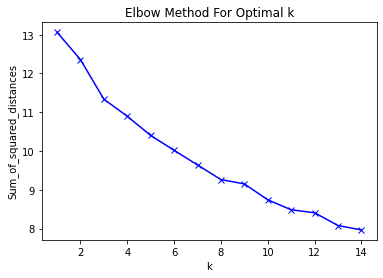

In [184]:
# finding optimal k number
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(moscow_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

# plotting the graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [185]:
# set optimal number of clusters as 6
kclusters = 9

moscow_grouped_clustering = moscow_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 0, 4, 4, 4, 4, 4, 2], dtype=int32)

In [186]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

moscow_merged = moscow_data

# merge moscow_grouped with moscow_data to add latitude/longitude for each neighborhood
moscow_merged = moscow_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

moscow_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",55.81002,37.53677,4.0,Food & Drink Shop,Gym / Fitness Center,Fruit & Vegetable Store,Train Station,Hotel,Café,Pizza Place,Bistro,Liquor Store,Dumpling Restaurant
1,"Akademichesky District, Moscow",55.67862,37.58189,4.0,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Chinese Restaurant,Burger Joint,Wine Shop,Caucasian Restaurant,Arts & Crafts Store,Café,Pizza Place
2,"Alexeyevsky District, Moscow",55.75696,37.61502,4.0,Boutique,Historic Site,Coffee Shop,Theater,Cosmetics Shop,Hotel,Fountain,Shoe Store,Russian Restaurant,Plaza
3,"Altufyevsky District, Moscow",55.88007,37.58305,0.0,Supermarket,Health Food Store,Café,Lake,Bus Line,Grocery Store,Salon / Barbershop,Auto Workshop,Gym Pool,Frozen Yogurt Shop
4,"Babushkinsky District, Moscow",55.86833,37.66389,4.0,Cosmetics Shop,Pharmacy,Supermarket,Plaza,Blini House,Health Food Store,Convenience Store,Middle Eastern Restaurant,Mobile Phone Shop,Sushi Restaurant


In [187]:
# drop rows with empty values
moscow_merged.dropna(inplace=True)
moscow_merged.reset_index(drop=True, inplace=True)

In [188]:
# changing data type of 'Cluster Labels' column to int
moscow_merged = moscow_merged.astype({'Cluster Labels': int})
moscow_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",55.81002,37.53677,4,Food & Drink Shop,Gym / Fitness Center,Fruit & Vegetable Store,Train Station,Hotel,Café,Pizza Place,Bistro,Liquor Store,Dumpling Restaurant
1,"Akademichesky District, Moscow",55.67862,37.58189,4,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Chinese Restaurant,Burger Joint,Wine Shop,Caucasian Restaurant,Arts & Crafts Store,Café,Pizza Place
2,"Alexeyevsky District, Moscow",55.75696,37.61502,4,Boutique,Historic Site,Coffee Shop,Theater,Cosmetics Shop,Hotel,Fountain,Shoe Store,Russian Restaurant,Plaza
3,"Altufyevsky District, Moscow",55.88007,37.58305,0,Supermarket,Health Food Store,Café,Lake,Bus Line,Grocery Store,Salon / Barbershop,Auto Workshop,Gym Pool,Frozen Yogurt Shop
4,"Babushkinsky District, Moscow",55.86833,37.66389,4,Cosmetics Shop,Pharmacy,Supermarket,Plaza,Blini House,Health Food Store,Convenience Store,Middle Eastern Restaurant,Mobile Phone Shop,Sushi Restaurant


# Plotting results

In [189]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_merged['Latitude'], moscow_merged['Longitude'], moscow_merged['Neighbourhood'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [190]:
# forming resulting dataframe
moscow_res = pd.DataFrame()
moscow_res['Neighbourhood'] = moscow_merged['Neighbourhood']
moscow_res['Cluster Labels'] = moscow_merged['Cluster Labels']

for i in range(3, 14):
    moscow_res[moscow_merged.columns[i]] = moscow_merged[moscow_merged.columns[i]]

moscow_res.head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",4,Food & Drink Shop,Gym / Fitness Center,Fruit & Vegetable Store,Train Station,Hotel,Café,Pizza Place,Bistro,Liquor Store,Dumpling Restaurant
1,"Akademichesky District, Moscow",4,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Chinese Restaurant,Burger Joint,Wine Shop,Caucasian Restaurant,Arts & Crafts Store,Café,Pizza Place
2,"Alexeyevsky District, Moscow",4,Boutique,Historic Site,Coffee Shop,Theater,Cosmetics Shop,Hotel,Fountain,Shoe Store,Russian Restaurant,Plaza
3,"Altufyevsky District, Moscow",0,Supermarket,Health Food Store,Café,Lake,Bus Line,Grocery Store,Salon / Barbershop,Auto Workshop,Gym Pool,Frozen Yogurt Shop
4,"Babushkinsky District, Moscow",4,Cosmetics Shop,Pharmacy,Supermarket,Plaza,Blini House,Health Food Store,Convenience Store,Middle Eastern Restaurant,Mobile Phone Shop,Sushi Restaurant


# Taking a look to each cluster

In [191]:
# Cluster Num 0
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 0].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 0].head(10)

Number of districts: 37


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Altufyevsky District, Moscow",0,Supermarket,Health Food Store,Café,Lake,Bus Line,Grocery Store,Salon / Barbershop,Auto Workshop,Gym Pool,Frozen Yogurt Shop
10,"Biryulyovo Zapadnoye District, Moscow",0,Supermarket,Pool,Hockey Rink,Park,Bus Stop,Italian Restaurant,Gastropub,Garden Center,Garden,Forest
11,"Bogorodskoye District, Moscow",0,Supermarket,Pharmacy,Bus Stop,Eastern European Restaurant,Tram Station,Health Food Store,Smoke Shop,Gym / Fitness Center,Fruit & Vegetable Store,Fried Chicken Joint
12,"Businovo District, Moscow",0,Supermarket,Electronics Store,Shopping Mall,Pool,Skate Park,Gastropub,Gay Bar,Garden Center,Garden,Gelato Shop
14,"Chertanovo Severnoye District, Moscow",0,Gym,Cosmetics Shop,Eastern European Restaurant,Wine Shop,Supermarket,Grocery Store,Bookstore,Furniture / Home Store,Athletics & Sports,Soccer Field
15,"Chertanovo Tsentralnoye District, Moscow",0,Gym,Cosmetics Shop,Eastern European Restaurant,Wine Shop,Supermarket,Grocery Store,Bookstore,Furniture / Home Store,Athletics & Sports,Soccer Field
16,"Chertanovo Yuzhnoye District, Moscow",0,Supermarket,Farmers Market,Bus Stop,Restaurant,Martial Arts School,Rock Club,Dessert Shop,Pizza Place,Flea Market,Pharmacy
25,"Golyanovo District, Moscow",0,Bus Stop,Toy / Game Store,Park,Shoe Store,Shopping Mall,Pharmacy,Salon / Barbershop,Bike Trail,Athletics & Sports,Lake
31,"Khovrino District, Moscow",0,Supermarket,Café,Pizza Place,Japanese Restaurant,Salon / Barbershop,Notary,Sushi Restaurant,Grocery Store,Gym / Fitness Center,Health & Beauty Service
32,"Konkovo District, Moscow",0,Supermarket,Baby Store,Grocery Store,Auto Workshop,Café,Health Food Store,Modern European Restaurant,Coffee Shop,Hookah Bar,Bar


In [192]:
# Cluster Num 1
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 1].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 1].head(10)

Number of districts: 1


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,"Nekrasovka District, Moscow",1,Bus Stop,Flower Shop,Garden,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Zoo Exhibit,Fountain


In [193]:
# Cluster Num 2
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 2].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 2].head(10)

Number of districts: 4


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Biryulyovo Vostochnoye District, Moscow",2,Supermarket,Park,Athletics & Sports,Nightclub,Gym / Fitness Center,Beer Store,Zoo Exhibit,Insurance Office,Gift Shop,Gelato Shop
47,"Lyublino District, Moscow",2,Food & Drink Shop,Pizza Place,Playground,Park,Fruit & Vegetable Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Forest
86,"Severny District, Moscow",2,Supermarket,Dessert Shop,Park,Playground,Furniture / Home Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Gaming Cafe
116,"Yuzhnoye Tushino District, Moscow",2,Park,Supermarket,Gym,Convenience Store,Pizza Place,Bath House,Gastropub,Garden Center,Garden,Fountain


In [194]:
# Cluster Num 3
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 3].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 3].head(10)

Number of districts: 2


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,"Kryukovo District, Moscow",3,Cafeteria,Gift Shop,Beer Bar,Flower Shop,Zoo Exhibit,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden
106,"Vostochnoye Izmaylovo District, Moscow",3,Flower Shop,Beer Bar,Café,Zoo Exhibit,Gaming Cafe,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,French Restaurant


In [195]:
# Cluster Num 4
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 4].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 4].head(10)

Number of districts: 63


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",4,Food & Drink Shop,Gym / Fitness Center,Fruit & Vegetable Store,Train Station,Hotel,Café,Pizza Place,Bistro,Liquor Store,Dumpling Restaurant
1,"Akademichesky District, Moscow",4,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Chinese Restaurant,Burger Joint,Wine Shop,Caucasian Restaurant,Arts & Crafts Store,Café,Pizza Place
2,"Alexeyevsky District, Moscow",4,Boutique,Historic Site,Coffee Shop,Theater,Cosmetics Shop,Hotel,Fountain,Shoe Store,Russian Restaurant,Plaza
4,"Babushkinsky District, Moscow",4,Cosmetics Shop,Pharmacy,Supermarket,Plaza,Blini House,Health Food Store,Convenience Store,Middle Eastern Restaurant,Mobile Phone Shop,Sushi Restaurant
5,"Basmanny District, Moscow",4,Coffee Shop,Caucasian Restaurant,Hookah Bar,Recording Studio,Clothing Store,Café,Yoga Studio,Dance Studio,Brewery,Hotel
6,"Begovoy District, Moscow",4,Food & Drink Shop,Pharmacy,Dog Run,Playground,Cafeteria,Café,Fruit & Vegetable Store,Gym / Fitness Center,Health Food Store,Coffee Shop
7,"Beskudnikovsky District, Moscow",4,Metro Station,Food & Drink Shop,Fast Food Restaurant,Park,Plaza,Asian Restaurant,Clothing Store,Pizza Place,Automotive Shop,Zoo Exhibit
8,"Bibirevo District, Moscow",4,Pizza Place,Supermarket,Gym / Fitness Center,Pet Store,Japanese Restaurant,Deli / Bodega,Butcher,Cafeteria,Shop & Service,Shipping Store
17,"Cheryomushki District, Moscow",4,Salon / Barbershop,Playground,Furniture / Home Store,Men's Store,Café,Convenience Store,Shopping Mall,Caucasian Restaurant,Dance Studio,Grocery Store
18,"Danilovsky District, Moscow",4,Beer Store,Electronics Store,Hookah Bar,Sporting Goods Shop,Café,Furniture / Home Store,Tea Room,Mobile Phone Shop,Shawarma Place,Performing Arts Venue


In [196]:
# Cluster Num 5
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 5].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 5].head(10)

Number of districts: 8


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,"Golovinsky District, Moscow",5,Auto Workshop,Pizza Place,Supermarket,Convenience Store,Pet Store,Food & Drink Shop,Pharmacy,Brewery,Waterfall,Fast Food Restaurant
37,"Krylatskoye District, Moscow",5,Pizza Place,Track,Salon / Barbershop,Auto Workshop,Athletics & Sports,Gastropub,Garden Center,Garden,Gay Bar,Gaming Cafe
66,"Ochakovo-Matveyevskoye District, Moscow",5,Auto Workshop,Buffet,Other Repair Shop,Furniture / Home Store,Warehouse Store,Bath House,Zoo Exhibit,Gaming Cafe,Fried Chicken Joint,Frozen Yogurt Shop
88,"Silino District, Moscow",5,Golf Course,Arcade,Auto Workshop,Gaming Cafe,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden
99,"Troparyovo-Nikulino District, Moscow",5,Auto Workshop,Supermarket,Park,Health Food Store,Flower Shop,Bakery,Men's Store,Salon / Barbershop,Asian Restaurant,Department Store
100,"Tsaritsyno District, Moscow",5,Auto Workshop,Supermarket,Food & Drink Shop,Bus Stop,Gaming Cafe,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden
105,"Vostochnoye Degunino District, Moscow",5,Supermarket,Park,Auto Workshop,Bus Stop,Gaming Cafe,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden
111,"Yaroslavsky District, Moscow",5,Auto Workshop,Park,Coffee Shop,Concert Hall,Grocery Store,Photography Studio,Fountain,Pizza Place,Fried Chicken Joint,Frozen Yogurt Shop


## Reviewing two main clusters

In [199]:
# Living cluster?
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 0].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 0].head(5)

Number of districts: 37


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Altufyevsky District, Moscow",0,Supermarket,Health Food Store,Café,Lake,Bus Line,Grocery Store,Salon / Barbershop,Auto Workshop,Gym Pool,Frozen Yogurt Shop
10,"Biryulyovo Zapadnoye District, Moscow",0,Supermarket,Pool,Hockey Rink,Park,Bus Stop,Italian Restaurant,Gastropub,Garden Center,Garden,Forest
11,"Bogorodskoye District, Moscow",0,Supermarket,Pharmacy,Bus Stop,Eastern European Restaurant,Tram Station,Health Food Store,Smoke Shop,Gym / Fitness Center,Fruit & Vegetable Store,Fried Chicken Joint
12,"Businovo District, Moscow",0,Supermarket,Electronics Store,Shopping Mall,Pool,Skate Park,Gastropub,Gay Bar,Garden Center,Garden,Gelato Shop
14,"Chertanovo Severnoye District, Moscow",0,Gym,Cosmetics Shop,Eastern European Restaurant,Wine Shop,Supermarket,Grocery Store,Bookstore,Furniture / Home Store,Athletics & Sports,Soccer Field


In [200]:
# Entertainment cluster?
print('Number of districts:', moscow_res.loc[moscow_res['Cluster Labels'] == 4].shape[0])
moscow_res.loc[moscow_res['Cluster Labels'] == 4].head(5)

Number of districts: 63


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aeroport District, Moscow",4,Food & Drink Shop,Gym / Fitness Center,Fruit & Vegetable Store,Train Station,Hotel,Café,Pizza Place,Bistro,Liquor Store,Dumpling Restaurant
1,"Akademichesky District, Moscow",4,Convenience Store,Vietnamese Restaurant,Gym / Fitness Center,Chinese Restaurant,Burger Joint,Wine Shop,Caucasian Restaurant,Arts & Crafts Store,Café,Pizza Place
2,"Alexeyevsky District, Moscow",4,Boutique,Historic Site,Coffee Shop,Theater,Cosmetics Shop,Hotel,Fountain,Shoe Store,Russian Restaurant,Plaza
4,"Babushkinsky District, Moscow",4,Cosmetics Shop,Pharmacy,Supermarket,Plaza,Blini House,Health Food Store,Convenience Store,Middle Eastern Restaurant,Mobile Phone Shop,Sushi Restaurant
5,"Basmanny District, Moscow",4,Coffee Shop,Caucasian Restaurant,Hookah Bar,Recording Studio,Clothing Store,Café,Yoga Studio,Dance Studio,Brewery,Hotel


# (OwO)